In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from datetime import datetime, timedelta, date
import dateutil

from statistics import mean, median
from scipy.stats import mode

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/adamskrocki/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/Users/adamskrocki/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Stocks Data

In [2]:
stocks = ['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG']
indices = ['^DJI', '^GSPC']
diffCols = ['Close']

# Adds a column to df for the day by day change of col
def add_day_change(df, cols):
    for col in cols:
        try:
            df[col + '_Diff'] = pd.to_numeric(df[col]).pct_change()
            df[col + "_Diff_Increase"] = df[col + '_Diff'] > 0
        except:
            print(f"Unable to calculate diff for {col}")
            
def add_moving_avg(df, col, n):
    try:
        df[f"Moving_Avg_{col}_{n}"] = df[col].rolling(window=n).mean().shift(1)
    except:
        print(f"Unable to calculate moving avg for {col}")

# Market dfs will store all of our dataframes for stock market data
market_dfs = {}
for symbol in stocks + indices:
    market_dfs[symbol] = pd.read_csv("../Additional Data/" + symbol + '.csv')
    add_day_change(market_dfs[symbol], diffCols)
    market_dfs[symbol]['Date'] = market_dfs[symbol]['Date'].apply(lambda x: dateutil.parser.parse(x).date())
    market_dfs[symbol].dropna(inplace=True)

In [3]:
market_dfs["^GSPC"].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Diff,Close_Diff_Increase
1,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000,-0.018278,False
2,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000,-0.008893,False
3,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000,0.011630,True
4,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000,0.017888,True
5,2015-01-09,2063.449951,2064.429932,2038.329956,2044.810059,2044.810059,3364140000,-0.008404,False


In [4]:
# Plots a trend for a symbol in the dfs dictionary for the col specified. Standardized divides all data by the mean
def plot_trend(df, col, standardize=False):
    # Figsize
    plt.figure(figsize=(10,6))
    
    # Plot stock price
    trend = df[col] / np.mean(df[col]) if standardize else df[col]
    plt.plot(trend)
    date = df.Date
        
    # Plot config
    locs, _ = plt.xticks()
    plt.xticks(locs[1:-1], date[0:-1:len(date)//(len(locs)-3)])
    plt.title(f'Standardized {col} over Time' if standardize else f'{col} over Time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.show()

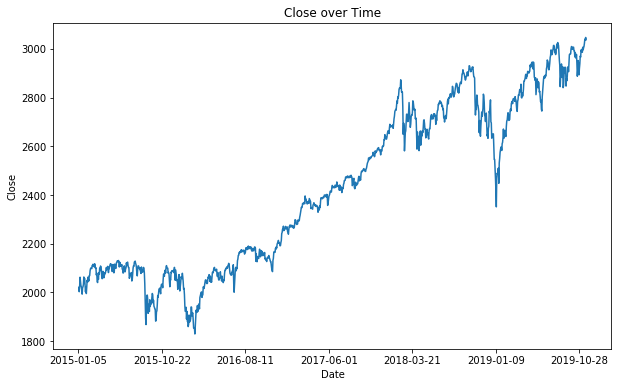

In [5]:
plot_trend(market_dfs["^GSPC"], 'Close')

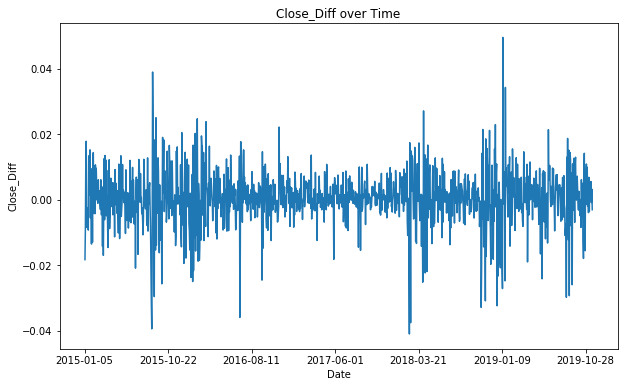

In [6]:
plot_trend(market_dfs["^GSPC"], 'Close_Diff')

## News Data

In [14]:
news = pd.concat([pd.read_csv('../nytimes_2015.csv'), 
                  pd.read_csv('../nytimes_2016.csv'), 
                  pd.read_csv('../nytimes_2017.csv'), 
                  pd.read_csv('../nytimes_2018.csv'), 
                  pd.read_csv('../nytimes_2019.csv')], ignore_index=True)

In [8]:
print(len(news))
news.head()

82533


,web_url,snippet,lead_paragraph,abstract,print_page,source,headline,headline_kicker,headline_content_kicker,headline_print_headline,...,headline_seo,headline_sub,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,word_count
0,https://www.nytimes.com/2015/01/08/world/ameri...,"Born through a mix of frustration, satire and ...","MONTERREY, Mexico — Inside a large, open-air b...","Born through a mix of frustration, satire and ...",9.0,The New York Times,A Bus Takes a Local Route to Fighting Mexican ...,Monterrey Journal,NaN,A Bus Takes a Local Route to Fighting Mexican ...,...,NaN,NaN,"[{'name': 'persons', 'value': 'Villegas, Pauli...",2015-01-08T00:45:08+0000,article,Foreign,World,"{'original': 'By Paulina Villegas', 'person': ...",News,1030
1,https://www.nytimes.com/2015/01/11/business/mu...,So-called dark trading — when computers serve ...,"JUDGING solely by the name, stock trading in s...",So-called dark trading — when computers serve ...,29.0,The New York Times,The Rise of Trading in the Dark,Datapoints,NaN,The Rise of Trading in the Dark,...,NaN,NaN,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:44:42+0000,article,SundayBusiness,Business Day,"{'original': 'By Anna Bernasek', 'person': [{'...",News,366
2,https://www.nytimes.com/2015/01/11/business/fo...,"In the fixed-income market, 2014 was frustrati...",BONDS confounded conventional wisdom in 2014 w...,"In the fixed-income market, 2014 was frustrati...",16.0,The New York Times,"For Bond Investors, That Other Shoe Still Didn...",NaN,NaN,"For Bond Investors, the Other Shoe Still Didn’...",...,NaN,NaN,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:46:05+0000,article,NODESK,Business Day,"{'original': 'By Carla Fried', 'person': [{'fi...",News,1269
3,https://www.nytimes.com/2015/01/11/business/pe...,A Canadian investor takes a chance on a pace-s...,The typical origin story for a tech company in...,A Canadian investor takes a chance on a pace-s...,1.0,The New York Times,The Uphill Push to Save a Bike-Share Pioneer,NaN,NaN,The Uphill Push to Save a Bike-Share Pioneer,...,NaN,NaN,"[{'name': 'subject', 'value': 'Bicycles and Bi...",2015-01-09T21:03:51+0000,article,SundayBusiness,Business Day,"{'original': 'By Ian Austen', 'person': [{'fir...",News,1923
4,https://www.nytimes.com/2015/01/06/business/in...,"The euro's continued plunge, to a nine-year lo...",FRANKFURT — The value of the euro fell to its ...,"The euro's continued plunge, to a nine-year lo...",5.0,The New York Times,Falling Euro Fans Fears of a Regional Slowdown,NaN,NaN,Sliding Euro Fans Fears of a Slowdown,...,NaN,NaN,"[{'name': 'persons', 'value': 'Ewing, Jack', '...",2015-01-05T21:05:04+0000,article,Business,Business Day,"{'original': 'By Jack Ewing', 'person': [{'fir...",News,1157


### Delete Irrelevant Columns

In [9]:
try: 
    news = news.drop(['web_url', 'byline', 'headline_print_headline', 'document_type'], axis=1)

    # these are missing more than abstract and contain similar info
    news = news.drop(['snippet', 'lead_paragraph'], axis=1)

    # all missing data
    news = news.drop(['headline_content_kicker', 'headline_name', 'headline_seo', 'headline_sub'], axis=1)
    print("Dropped columns")
except: 
    pass 

Dropped columns


### Transform Columns to be More Useful

In [13]:
try:
    # make headline include kicker
    news['full_headline'] = news[['headline', 'headline_kicker']].apply(lambda x: x.str.cat(sep=': '), axis=1)

    del news['headline_kicker']
    del news['headline']

    # create whether or not the article was in print
    news['is_print'] = news['print_page'].isna()
    del news['print_page']
    print("Transformed columns")
except:
    pass

list(news.columns)
news.shape

(82533, 10)

### Change to One-Hot Encoding

In [11]:
# from type of material
type_dummies = pd.get_dummies(news['type_of_material'].fillna('Other'), prefix='Type')
news = pd.concat([news, type_dummies], axis=1, join='inner')
news.rename(columns={'Type_briefing': 'Type_Briefing'}, inplace=True)

del news['type_of_material']

In [12]:
# from source
source_dummies = pd.get_dummies(news['source'].fillna('Other'), prefix='Source')
news = pd.concat([news, source_dummies], axis=1, join='inner')

del news['source']

In [13]:
# from news desk
news_desk_dummies = pd.get_dummies(news['news_desk'].fillna('Other'), prefix='Desk')
news = pd.concat([news, news_desk_dummies], axis=1, join='inner')

del news['news_desk']

In [14]:
# from section name
section_name_dummies = pd.get_dummies(news['section_name'], prefix='Section')
news = pd.concat([news, section_name_dummies], axis=1, join='inner')

del news['section_name']

### Change Keywords to Many-Hot Encoding

In [15]:
import ast
from collections import Counter

counter = Counter()

# Get list of all keywords
def get_most_common(x):
    keywords = set()
    for word in ast.literal_eval(x):
        keywords.add(word['value'])
    counter.update(keywords)
    return keywords

news['keywords'] = news['keywords'].apply(get_most_common)

# Pick top 1000
most_common = set()
for word, counts in counter.most_common(1000):
    most_common.add(word)

# Get the intersection of article's keywords and top 100
def get_keywords(x):
    keywords = x.intersection(most_common)
    return '|'.join(keywords)

# Many-hot
keywords_dummies = news['keywords'].apply(get_keywords).str.get_dummies()
keywords_dummies.rename(columns={x: 'Keyword_' + x for x in keywords_dummies.columns}, inplace=True)
news = pd.concat([news, keywords_dummies], axis=1, join='inner')

del news['keywords']

### Time & Date

In [16]:
if 'pub_date' in news.columns:
    news['hour'] = news['pub_date'].apply(lambda x: dateutil.parser.parse(x).time().hour)
    news['date'] = news['pub_date'].apply(lambda x: dateutil.parser.parse(x).date() + timedelta(days=1))
    del news['pub_date']

### Sentiment Analysis

In [17]:
# Adds sentiment by TextBlob (polarity and subjectivity) to a df based on its col column
def add_textblob_sentiment(df, col):
    def polarity_and_subjectivity(x):
        sentiment = TextBlob(str(x)).sentiment
        return sentiment.polarity, sentiment.subjectivity
    df[f'{col}_polarity'], df[f'{col}_subjectivity'] = zip(*df[col].map(polarity_and_subjectivity))
    
def add_nltk_sentiment(df, col):
    sid = SentimentIntensityAnalyzer()
    def polarity_and_subjectivity(x):
        sentiment = sid.polarity_scores(str(x))
        return list(sentiment.values())
    df[f'{col}_neg'], df[f'{col}_neu'], df[f'{col}_pos'], df[f'{col}_compound'] = zip(*df[col].map(polarity_and_subjectivity))

In [18]:
if 'abstract' in news.columns and 'full_headline' in news.columns: 
    add_textblob_sentiment(news, 'abstract')
    add_textblob_sentiment(news, 'full_headline')
    add_nltk_sentiment(news, 'abstract')
    add_nltk_sentiment(news, 'full_headline')
    news = news.drop(['abstract'], axis=1)

## Bag of Words Models

In [49]:
# classifier
for symbol in stocks + indices:
    print(symbol)

    # group all articles for each day
    df = pd.DataFrame(news.groupby('date')['full_headline'].apply(lambda x: ' '.join(x))).merge(market_dfs[symbol], left_on='date', right_on='Date')
    df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close_Diff'], axis=1)

    train = df[df['Date'].apply(lambda x: x < dateutil.parser.parse('2018-11-01').date())].reset_index(drop=True)
    test = df[df['Date'].apply(lambda x: x >= dateutil.parser.parse('2018-11-01').date())].reset_index(drop=True)

    vectorize = CountVectorizer(ngram_range=(2,2))
    train_vectorize = vectorize.fit_transform(train['full_headline'])
    test_vectorize = vectorize.transform(test['full_headline'])
    
    classifier = LogisticRegression(max_iter=1000, penalty='l1', C=1, solver='liblinear')
    classifier.fit(train_vectorize, train['Close_Diff_Increase'])

    print(classifier.score(test_vectorize, test['Close_Diff_Increase']))

AAPL
0.5856573705179283
FB
0.450199203187251
NFLX
0.5298804780876494
AMZN
0.549800796812749
GOOG
0.5099601593625498
^DJI
0.5378486055776892
^GSPC
0.5697211155378487


In [50]:
# regression
for symbol in stocks + indices:
    print(symbol)

    # group all articles for each day
    df = pd.DataFrame(news.groupby('date')['full_headline'].apply(lambda x: ' '.join(x))).merge(market_dfs[symbol], left_on='date', right_on='Date')
    df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Close_Diff_Increase'], axis=1)

    train = df[df['Date'].apply(lambda x: x < dateutil.parser.parse('2018-11-01').date())].reset_index(drop=True)
    test = df[df['Date'].apply(lambda x: x >= dateutil.parser.parse('2018-11-01').date())].reset_index(drop=True)

    vectorize = CountVectorizer(ngram_range=(2,2))
    train_vectorize = vectorize.fit_transform(train['full_headline'])
    test_vectorize = vectorize.transform(test['full_headline'])
    
    reg = LinearRegression()
    reg.fit(train_vectorize, train['Close_Diff'])

    print(mean_squared_error(test['Close_Diff'], reg.predict(test_vectorize)))
    

AAPL
0.0003900487219754105
FB
0.00041068732246477674
NFLX
0.0006333879484441252
AMZN
0.0003903427822283333
GOOG
0.0003010132565824724
^DJI
9.953919470454011e-05
^GSPC
9.77064388541399e-05


## Create train/ test datasets for easy model testing

In [29]:
full_dfs = {}
for symbol in stocks + indices: 
    df = news.merge(market_dfs[symbol], left_on='date', right_on='Date')
    df = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

    train = df[df['date'].apply(lambda x: x < dateutil.parser.parse('2018-11-01').date())].reset_index(drop=True)
    test = df[df['date'].apply(lambda x: x >= dateutil.parser.parse('2018-11-01').date())].reset_index(drop=True)

    # bag of words on headline and then PCA and take first 10 components
    vectorize = CountVectorizer(ngram_range=(2,2))
    train_pca = vectorize.fit_transform(train['full_headline'])
    test_pca = vectorize.transform(test['full_headline'])
    
    pca = TruncatedSVD(n_components=10)
    pca_df = pd.DataFrame(pca.fit_transform(train_pca), columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10'])
    train = pd.concat([train, pca_df.reindex(train.index)], axis=1)
    pca_df = pd.DataFrame(pca.transform(test_pca), columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10'])
    test = pd.concat([test, pca_df.reindex(test.index)], axis=1)
    
    train = train.drop(['full_headline'], axis=1)
    test = test.drop(['full_headline'], axis=1)
    
    full_dfs[symbol] = {'train': train, 'test': test}

In [62]:
# get X_train, Y_train, X_test, and Y_test
def get_x_y(x_columns, y_columns, train, test):
    return train[x_columns], test[x_columns], train[y_columns], test[y_columns]

In [58]:
# average the articles for each day and get X_train, Y_train, X_test, and Y_test
def get_x_y_average(x_columns, y_columns, train, test):
    train = train.groupby('date').mean().reset_index(drop=True)
    test = test.groupby('date').mean().reset_index(drop=True)
    return train[x_columns], test[x_columns], train[y_columns], test[y_columns]

In [10]:
def average(results):
    return sum(results) / len(results)

# weight classification error by how much the market moved
def weighted_average(results, weights):
    return results.dot(abs(weights)) / sum(abs(weights))

## Models

In [87]:
# Logistic regression with PCA on all features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y(
        full_dfs[symbol]['train'].columns.drop(['date', 'Close_Diff', 'Close_Diff_Increase']), 
        ['date', 'Close_Diff', 'Close_Diff_Increase'], 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )
    
    scaler = StandardScaler()
    pca = PCA(n_components=5)
    
    classifier = LogisticRegression(max_iter=1000, penalty='l1', C=1, solver='liblinear')
    classifier.fit(pca.fit_transform(scaler.fit_transform(X_train)), Y_train['Close_Diff_Increase'])

    X_test = pd.DataFrame(pca.transform(scaler.transform(X_test)))
    X_test['date'] = Y_test['date'].values
    predictions = X_test.groupby('date').apply(classifier.predict).apply(lambda x: mode(x)[0])
    results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
    print(f'Average: {average(results)}')
    print('Weighted Average: {}'.format(weighted_average(results, Y_test.groupby('date').first()['Close_Diff'])))

AAPL


/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Average: 0.5378486055776892
Weighted Average: 0.525031861642065
FB


/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Average: 0.49800796812749004
Weighted Average: 0.5225823224897267
NFLX


/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Average: 0.4860557768924303
Weighted Average: 0.48945020367587555
AMZN


/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Average: 0.5298804780876494
Weighted Average: 0.5224052615088606
GOOG


/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Average: 0.5219123505976095
Weighted Average: 0.5330720008186741
^DJI


/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Average: 0.545816733067729
Weighted Average: 0.5248096764140403
^GSPC


/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Abby/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


Average: 0.5577689243027888
Weighted Average: 0.5359006262332655


In [31]:
# Linear regression with average across day with all features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y_average(
        full_dfs[symbol]['train'].columns.drop(['date', 'Close_Diff', 'Close_Diff_Increase']), 
        'Close_Diff', 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    regressor = LinearRegression()
    regressor.fit(X_train, Y_train)

    print(mean_squared_error(Y_test, regressor.predict(X_test)))

AAPL
0.004801978374477705
FB
0.007857353389514403
NFLX
0.016376986716709906
AMZN
0.00945374144760702
GOOG
0.00720401193165237
^DJI
0.0015902343599479322
^GSPC
0.001613102163909155


In [77]:
# Logistic regression with average across day with all features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y_average(
        full_dfs[symbol]['train'].columns.drop(['date', 'Close_Diff', 'Close_Diff_Increase']), 
        'Close_Diff_Increase', 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    regressor = LogisticRegression(max_iter=10000, solver='lbfgs')
    regressor.fit(X_train, Y_train)

    print(regressor.score(X_test, Y_test))

AAPL
0.4940239043824701
FB
0.47808764940239046
NFLX
0.4701195219123506
AMZN
0.5099601593625498
GOOG
0.5378486055776892
^DJI
0.545816733067729
^GSPC
0.5378486055776892


In [78]:
# Logistic regression with average across day with only bag of words PCA and sentiment
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y_average(
        ['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'full_headline_neg', 'full_headline_neu', 'full_headline_pos', 'full_headline_compound', 'abstract_neg', 'abstract_neu', 'abstract_compound', 'abstract_pos'], 
        'Close_Diff_Increase', 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    regressor = LogisticRegression(max_iter=10000, solver='lbfgs')
    regressor.fit(X_train, Y_train)

    print(regressor.score(X_test, Y_test))

AAPL
0.5338645418326693
FB
0.5179282868525896
NFLX
0.49800796812749004
AMZN
0.5298804780876494
GOOG
0.5298804780876494
^DJI
0.545816733067729
^GSPC
0.5617529880478087


In [63]:
# Logistic regression with all features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y(
        full_dfs[symbol]['train'].columns.drop(['Close_Diff', 'Close_Diff_Increase']), 
        ['date', 'Close_Diff', 'Close_Diff_Increase'], 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    classifier = LogisticRegression(max_iter=1000, penalty='l1', C=1, solver='liblinear')
    classifier.fit(X_train.drop(['date'], axis=1), Y_train['Close_Diff_Increase'])

    predictions = X_test.groupby('date').apply(classifier.predict).apply(lambda x: mode(x)[0])
    results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
    print(f'Average: {average(results)}')
    print('Weighted Average: {}'.format(weighted_average(results, Y_test.groupby('date').first()['Close_Diff'])))

AAPL
Average: 0.5219123505976095
Weighted Average: 0.5244296521407597
FB
Average: 0.5338645418326693
Weighted Average: 0.5400937488885611
NFLX
Average: 0.5099601593625498
Weighted Average: 0.5117967587700238
AMZN
Average: 0.5258964143426295
Weighted Average: 0.5302111826087915
GOOG
Average: 0.5219123505976095
Weighted Average: 0.5434414198357912
^DJI
Average: 0.545816733067729
Weighted Average: 0.5252876106391109
^GSPC
Average: 0.549800796812749
Weighted Average: 0.5312815362191463


In [65]:
# Logistic regression with only sentiment features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y(
        ['date', 'full_headline_neg', 'full_headline_neu', 'full_headline_pos', 'full_headline_compound', 'abstract_neg', 'abstract_neu', 'abstract_compound', 'abstract_pos'], 
        ['date', 'Close_Diff', 'Close_Diff_Increase'], 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    classifier = LogisticRegression(max_iter=1000, penalty='l1', C=1, solver='liblinear')
    classifier.fit(X_train.drop(['date'], axis=1), Y_train['Close_Diff_Increase'])

    predictions = X_test.groupby('date').apply(classifier.predict).apply(lambda x: mode(x)[0])
    results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
    print(f'Average: {average(results)}')
    print('Weighted Average: {}'.format(weighted_average(results, Y_test.groupby('date').first()['Close_Diff'])))

AAPL
Average: 0.5378486055776892
Weighted Average: 0.5253529867861133
FB
Average: 0.5139442231075697
Weighted Average: 0.5394878592075109
NFLX
Average: 0.4940239043824701
Weighted Average: 0.4966563914478604
AMZN
Average: 0.5298804780876494
Weighted Average: 0.5224052615088606
GOOG
Average: 0.5219123505976095
Weighted Average: 0.5330720008186741
^DJI
Average: 0.545816733067729
Weighted Average: 0.5248096764140403
^GSPC
Average: 0.5577689243027888
Weighted Average: 0.5359006262332655


In [66]:
# Logistic regression with only bag of words PCA features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y(
        ['date', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10'], 
        ['date', 'Close_Diff', 'Close_Diff_Increase'], 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    classifier = LogisticRegression(max_iter=1000, penalty='l1', C=1, solver='liblinear')
    classifier.fit(X_train.drop(['date'], axis=1), Y_train['Close_Diff_Increase'])

    predictions = X_test.groupby('date').apply(classifier.predict).apply(lambda x: mode(x)[0])
    results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
    print(f'Average: {average(results)}')
    print('Weighted Average: {}'.format(weighted_average(results, Y_test.groupby('date').first()['Close_Diff'])))

AAPL
Average: 0.5378486055776892
Weighted Average: 0.5253529867861133
FB
Average: 0.5139442231075697
Weighted Average: 0.5394878592075109
NFLX
Average: 0.50199203187251
Weighted Average: 0.5031425695003541
AMZN
Average: 0.5298804780876494
Weighted Average: 0.5224052615088606
GOOG
Average: 0.5219123505976095
Weighted Average: 0.5330720008186741
^DJI
Average: 0.545816733067729
Weighted Average: 0.5248096764140403
^GSPC
Average: 0.5577689243027888
Weighted Average: 0.5359006262332655


In [67]:
# Classification with linear regression with all features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y(
        full_dfs[symbol]['train'].columns.drop(['Close_Diff', 'Close_Diff_Increase']), 
        ['date', 'Close_Diff', 'Close_Diff_Increase'], 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    regressor = LinearRegression()
    regressor.fit(X_train.drop(['date'], axis=1), Y_train['Close_Diff'])

    predictions = X_test.groupby('date').apply(regressor.predict).apply(lambda x: median(x) > 0)
    results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
    print(f'Average: {average(results)}')
    print('Weighted Average: {}'.format(weighted_average(results, Y_test.groupby('date').first()['Close_Diff'])))

AAPL
Average: 0.5179282868525896
Weighted Average: 0.5110784570646426
FB
Average: 0.5378486055776892
Weighted Average: 0.5825166821146132
NFLX
Average: 0.4940239043824701
Weighted Average: 0.501229157150921
AMZN
Average: 0.5219123505976095
Weighted Average: 0.5175821818260528
GOOG
Average: 0.5099601593625498
Weighted Average: 0.5477922184997918
^DJI
Average: 0.5418326693227091
Weighted Average: 0.5253746508739032
^GSPC
Average: 0.5776892430278885
Weighted Average: 0.5744311305210266


In [69]:
# Linear regression with all features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y(
        full_dfs[symbol]['train'].columns.drop(['Close_Diff', 'Close_Diff_Increase']), 
        ['date', 'Close_Diff'], 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )

    regressor = LinearRegression()
    regressor.fit(X_train.drop(['date'], axis=1), Y_train['Close_Diff'])

    predictions = X_test.groupby('date').apply(regressor.predict).apply(median)
    print(mean_squared_error(Y_test.groupby('date').first()['Close_Diff'], predictions))

AAPL
0.0003868585165670449
FB
0.00040729329176409095
NFLX
0.0006215365808348696
AMZN
0.0003793477828953
GOOG
0.0002942817124558133
^DJI
9.800742814330056e-05
^GSPC
9.660513905721755e-05


In [73]:
# Stacked regression and classification with all features
for symbol in stocks + indices:
    print(symbol)

    X_train, X_test, Y_train, Y_test = get_x_y(
        full_dfs[symbol]['train'].columns.drop(['Close_Diff', 'Close_Diff_Increase']), 
        ['date', 'Close_Diff', 'Close_Diff_Increase'], 
        full_dfs[symbol]['train'], 
        full_dfs[symbol]['test']
    )
    X_train = X_train.drop(['date'], axis=1)

    # fit classifier model to predict increase/ decrease
    classifier1 = LogisticRegression(max_iter=10000, solver='lbfgs')
    classifier1.fit(X_train, Y_train['Close_Diff_Increase'])

    # fit classifier model to predict which are best
    classifier2 = LogisticRegression(max_iter=10000, solver='lbfgs')
    c1_accuracy = classifier1.predict(X_train) == Y_train['Close_Diff_Increase']
    classifier2.fit(X_train, c1_accuracy)

    # fit regression model to predict difference
    regressor = LinearRegression()
    x_train_with_importance = X_train
    x_train_with_importance.['importance'] = classifier2.predict(X_train)
    regressor.fit(x_train_with_importance, Y_train['Close_Diff'])

    x_test_with_importance = X_test
    x_test_with_importance.['importance'] = classifier2.predict(X_test.drop(['date'], axis=1))
    predictions = x_test_with_importance.groupby('date').apply(regressor.predict).apply(median)
    print('MSE: {}'.format(mean_squared_error(Y_test.groupby('date').first()['Close_Diff'], predictions)))
    
    predictions = x_test_with_importance.groupby('date').apply(regressor.predict).apply(lambda x: median(x) > 0)
    results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
    print(f'Average: {average(results)}')
    print('Weighted Average: {}'.format(weighted_average(results, Y_test.groupby('date').first()['Close_Diff'])))
    
    # fit classification model to predict increase/ decrease
    regressor = LogisticRegression(max_iter=10000, solver='lbfgs')
    regressor.fit(x_train_with_importance, Y_train['Close_Diff_Increase'])

    predictions = x_test_with_importance.groupby('date').apply(regressor.predict).apply(lambda x: mode(x)[0])
    results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
    print(f'Average: {average(results)}')
    print('Weighted Average: {}'.format(weighted_average(results, Y_test.groupby('date').first()['Close_Diff'])))

AAPL


/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSE: 0.00038786604906259297
Average: 0.5179282868525896
Weighted Average: 0.5108483613808856
Average: 0.5099601593625498
Weighted Average: 0.5079219609855401
FB


/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSE: 0.0004080889089439621
Average: 0.5378486055776892
Weighted Average: 0.5912867721250523
Average: 0.5219123505976095
Weighted Average: 0.5307197134978214
NFLX


/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSE: 0.0006218565648224291
Average: 0.5059760956175299
Weighted Average: 0.5133171464203858
Average: 0.4900398406374502
Weighted Average: 0.4804001050493781
AMZN


/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSE: 0.0003782059040303174
Average: 0.5298804780876494
Weighted Average: 0.5193483678349603
Average: 0.5258964143426295
Weighted Average: 0.52112896448347
GOOG


/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSE: 0.0002941877160755917
Average: 0.5099601593625498
Weighted Average: 0.547479421515392
Average: 0.5258964143426295
Weighted Average: 0.5355373205280896
^DJI


/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSE: 9.799727475496061e-05
Average: 0.545816733067729
Weighted Average: 0.5276721249420508
Average: 0.5418326693227091
Weighted Average: 0.5209541309965023
^GSPC


/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Abby/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MSE: 9.682482262926184e-05
Average: 0.5537848605577689
Weighted Average: 0.5217583272902468
Average: 0.5537848605577689
Weighted Average: 0.5223852122163499


## Graphs and Charts of Results

In [68]:
reg_models = pd.DataFrame(np.array([
    [0.0003900487219754105,
     0.00041068732246477674,
     0.0006333879484441252,
     0.0003903427822283333,
     0.0003010132565824724,
     9.953919470454011e-05,
     9.77064388541399e-05],
    [0.004801978374477705,
     0.007857353389514403,
     0.016376986716709906,
     0.00945374144760702,
     0.00720401193165237,
     0.0015902343599479322,
     0.001613102163909155],
    [0.0003868585165670449,
     0.00040729329176409095,
     0.0006215365808348696,
     0.0003793477828953,
     0.0002942817124558133,
     9.800742814330056e-05,
     9.660513905721755e-05], 
    [0.00038786604906259297,
     0.0004080889089439621,
     0.0006218565648224291,
     0.0003782059040303174,
     0.0002941877160755917,
     9.799727475496061e-05,
     9.682482262926184e-05]]), 
                          columns=['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG', '^DJI', '^GSPC'])
reg_models = reg_models.set_index(pd.Index(['Bag of Words', 'Days Average', 'All Articles', 'Stacked']))
reg_models

,AAPL,FB,NFLX,AMZN,GOOG,^DJI,^GSPC
Bag of Words,0.000390,0.000411,0.000633,0.000390,0.000301,0.000100,0.000098
Days Average,0.004802,0.007857,0.016377,0.009454,0.007204,0.001590,0.001613
All Articles,0.000387,0.000407,0.000622,0.000379,0.000294,0.000098,0.000097
Stacked,0.000388,0.000408,0.000622,0.000378,0.000294,0.000098,0.000097


In [67]:
class_models = pd.DataFrame(np.array([
    [0.5856573705179283,
0.450199203187251,
0.5298804780876494,
0.549800796812749,
0.5099601593625498,
0.5378486055776892,
0.5697211155378487],
    [0.5378486055776892,
0.49800796812749004,
0.4860557768924303,
0.5298804780876494,
0.5219123505976095,
0.545816733067729,
0.5577689243027888],
    [0.4940239043824701,
0.47808764940239046,
0.4701195219123506,
0.5099601593625498,
0.5378486055776892,
0.545816733067729,
0.5378486055776892], 
    [0.5338645418326693,
0.5179282868525896,
0.49800796812749004,
0.5298804780876494,
0.5298804780876494,
0.545816733067729,
0.5617529880478087], 
    [0.5219123505976095,
0.5338645418326693,
0.5099601593625498,
0.5258964143426295,
0.5219123505976095,
0.545816733067729,
0.549800796812749], 
    [0.5099601593625498,
0.5219123505976095,
0.4900398406374502,
0.5258964143426295,
0.5258964143426295,
0.5418326693227091,
0.5537848605577689]]), 
                          columns=['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG', '^DJI', '^GSPC'])
class_models = class_models.set_index(pd.Index(['Bag of Words', 'PCA All Features', 'Days Average', 'Days Average: Bag of Words PCA and Sentiment', 'All Articles', 'Stacked']))
class_models

,AAPL,FB,NFLX,AMZN,GOOG,^DJI,^GSPC
Bag of Words,0.585657,0.450199,0.529880,0.549801,0.509960,0.537849,0.569721
PCA All Features,0.537849,0.498008,0.486056,0.529880,0.521912,0.545817,0.557769
Days Average,0.494024,0.478088,0.470120,0.509960,0.537849,0.545817,0.537849
Days Average: Bag of Words PCA and Sentiment,0.533865,0.517928,0.498008,0.529880,0.529880,0.545817,0.561753
All Articles,0.521912,0.533865,0.509960,0.525896,0.521912,0.545817,0.549801
Stacked,0.509960,0.521912,0.490040,0.525896,0.525896,0.541833,0.553785


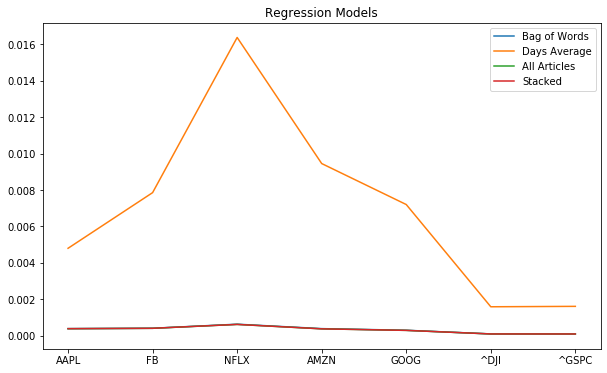

In [63]:
plt.figure(figsize=(10,6))

for i in range(len(reg_models)):
    plt.plot(range(len(stocks + indices)), reg_models.iloc[i])
    
plt.xticks(np.arange(7), reg_models.columns)
plt.gca().legend(['Bag of Words', 'Days Average', 'All Articles', 'Stacked'])
plt.title("Regression Models")
plt.show()

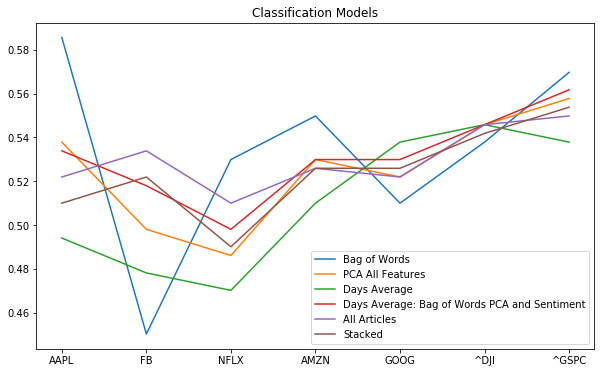

In [64]:
plt.figure(figsize=(10,6))

for i in range(len(class_models)):
    plt.plot(range(len(stocks + indices)), class_models.iloc[i])
    
plt.xticks(np.arange(7), class_models.columns)
plt.gca().legend(['Bag of Words', 'PCA All Features', 'Days Average', 'Days Average: Bag of Words PCA and Sentiment', 'All Articles', 'Stacked'])
plt.title("Classification Models")
plt.show()